# K-means Clustering

# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.cluster import KMeans

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train = True, transform = transform, download = True)
test_dataset  = datasets.MNIST(root='./data', train = False, transform = transform, download = True)

X_train = train_dataset.data.float().view(train_dataset.data.shape[0], -1) / 255.0
X_test  = test_dataset.data.float().view(test_dataset.data.shape[0], -1) / 255.0

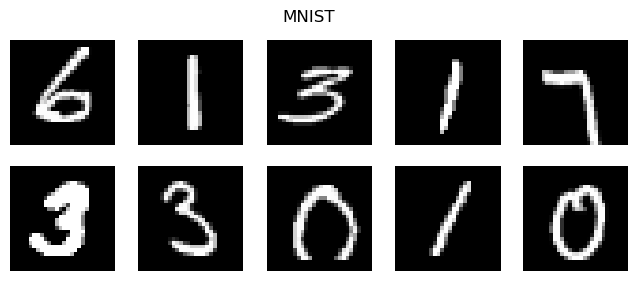

In [3]:
idx = np.random.choice(len(X_train), 10, replace = False)

plt.figure(figsize=(8, 3))
for i, index in enumerate(idx):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[index].numpy().reshape(28, 28), cmap="gray")
    plt.axis("off")

plt.suptitle("MNIST")
plt.show()

In [4]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
X_test  = X_test.to(device)

# 1. From Scratch

In [5]:
class KMeansAlgorithm:
    def __init__(self, k, max_iters = 100, tolerance = 1e-4):
        self.k = k
        self.max_iters = max_iters
        self.tolerance = tolerance
    
    def fit(self, X):
        torch.manual_seed(42)
        
        #Init centroids randomly
        self.centroids = X[torch.randint(0, X.shape[0], (self.k,))].clone().to(device)

        for _ in range(self.max_iters):
            #Euclidean-distance: point to centroid
            distances = torch.cdist(X, self.centroids)

            #Assign to centroid
            labels = torch.argmin(distances, dim = 1)

            #Upgrade centroids
            new_centroids = torch.stack([X[labels == i].mean(dim=0) for i in range(self.k)])

            #Stop-condition
            if torch.norm(new_centroids - self.centroids) < self.tolerance:
                break
            self.centroids = new_centroids

        self.labels = labels

    def predict(self, X):
        distances = torch.cdist(X, self.centroids)
        return torch.argmin(distances, dim=1)

In [6]:
kmeans_torch = KMeansAlgorithm(k = 10)
kmeans_torch.fit(X_train)

#Test labeling
y_pred_torch = kmeans_torch.predict(X_test)

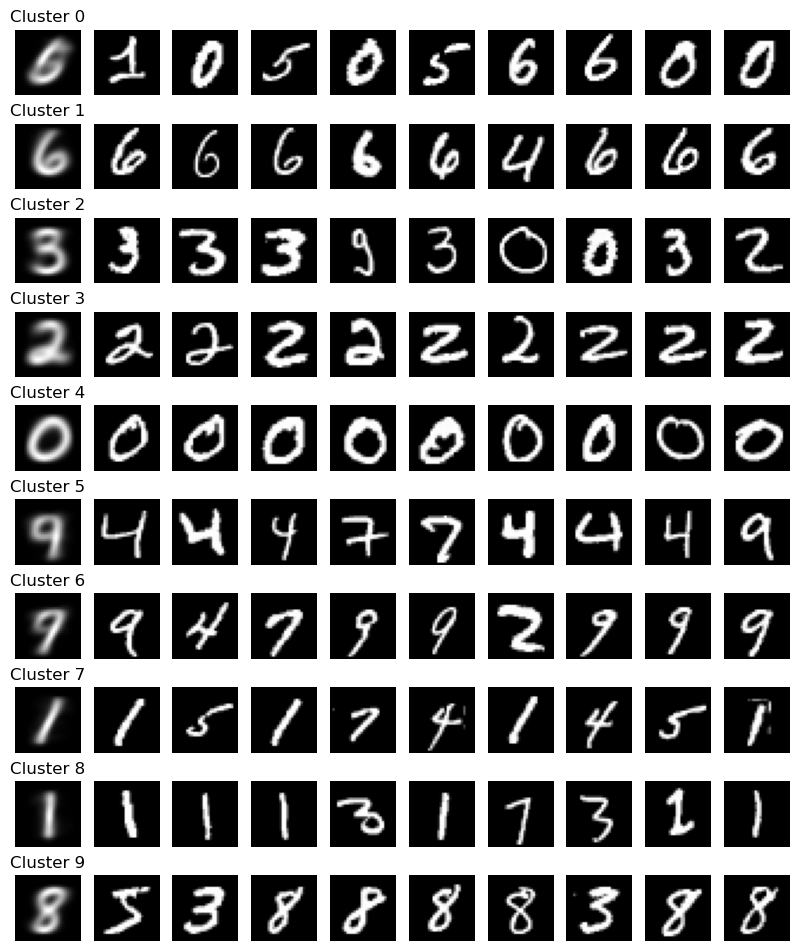

In [11]:
plt.figure(figsize=(10, 12))
for i in range(10):
    cluster_samples = X_train[kmeans_torch.labels == i][:9].cpu().numpy()
    
    #Centroids
    plt.subplot(10, 10, i * 10 + 1)
    plt.imshow(kmeans_torch.centroids[i].cpu().numpy().reshape(28, 28), cmap="gray")
    plt.title(f"Cluster {i}")
    plt.axis("off")
    
    #
    for j in range(9):
        plt.subplot(10, 10, i * 10 + j + 2)
        plt.imshow(cluster_samples[j].reshape(28, 28), cmap="gray")
        plt.axis("off")

plt.show()

# 2. Scikit-learn

In [12]:
kmeans_sklearn = KMeans(n_clusters = 10, random_state = 42)
kmeans_sklearn.fit(X_train.cpu().numpy())

#Test labeling
y_pred_sklearn = kmeans_sklearn.predict(X_test.cpu().numpy())

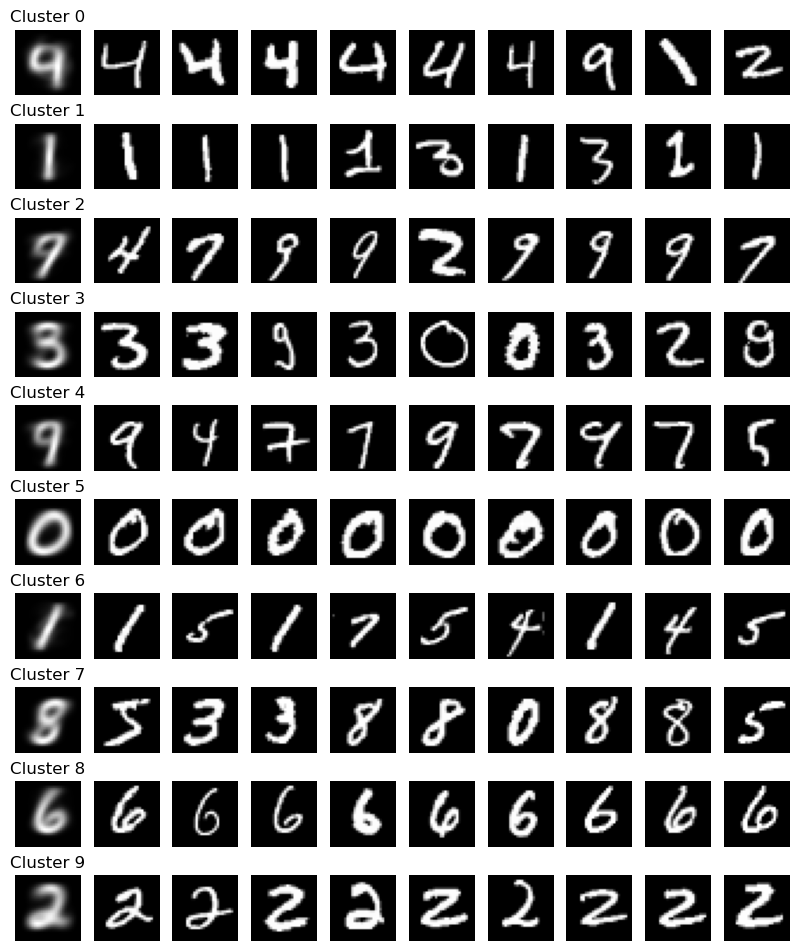

In [13]:
plt.figure(figsize=(10, 12))
for i in range(10):
    cluster_samples = X_train[kmeans_sklearn.labels_ == i][:9].cpu().numpy()
    
    #Centroid
    plt.subplot(10, 10, i * 10 + 1)
    plt.imshow(kmeans_sklearn.cluster_centers_[i].reshape(28, 28), cmap = "gray")
    plt.title(f"Cluster {i}")
    plt.axis("off")
    
    #Points
    for j in range(9):
        plt.subplot(10, 10, i * 10 + j + 2)
        plt.imshow(cluster_samples[j].reshape(28, 28), cmap="gray")
        plt.axis("off")

plt.show()

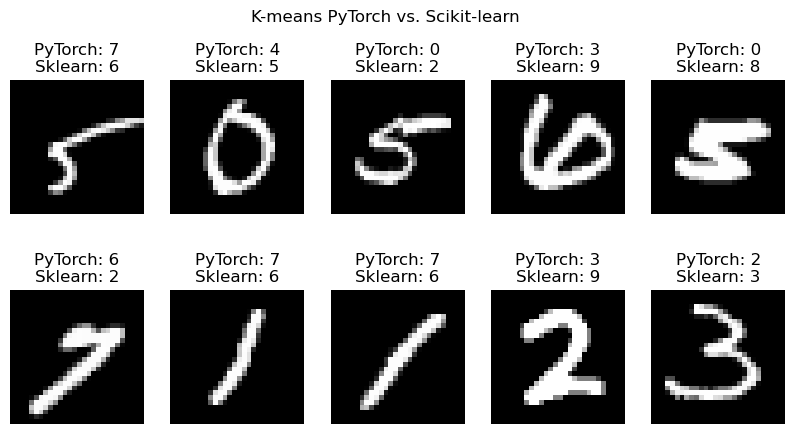

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

#Test
idx = np.random.choice(len(X_test), 10, replace=False)

for i, index in enumerate(idx):
    ax = axes[i // 5, i % 5]
    ax.imshow(X_test[index].cpu().numpy().reshape(28, 28), cmap="gray")
    ax.set_title(f"PyTorch: {y_pred_torch[index].item()}\nSklearn: {y_pred_sklearn[index]}")
    ax.axis("off")

plt.suptitle("K-means PyTorch vs. Scikit-learn")
plt.show()
#Note: Clustering only, labels are not used.

****